In [3]:
%matplotlib inline
%cd course-deep-learning/

import gdown
import time
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchsummary import summary
from tqdm import tqdm

from utils.adversarial_examples import *

/content/course-deep-learning


In [4]:
!mkdir ./data/
!cd ./data/ && mkdir AudioMNIST

!git clone https://github.com/soerenab/AudioMNIST.git
!cd ..

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30128, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 30128 (delta 3), reused 5 (delta 1), pack-reused 30119 (from 1)
Receiving objects: 100% (30128/30128), 944.54 MiB | 22.68 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Updating files: 100% (30018/30018), done.


In [5]:
# Adversarial examples: inputs to a model that have been modified, so the model makes an incorrect prediction.
# Simple MNIST classifier
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mnist_train, mnist_test = load_mnist() # predefine function call
model = MNISTClassifier()
model.to(device)
# train_mnist(model, mnist_train, mnist_test)
model.load_state_dict(torch.load('./utils/adversarial_examples/pretrained/mnist_classifier.pt', map_location=device))
print(summary(model, (1,28,28)))
# evaluate the model
test_mnist(model, device, mnist_test)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.75MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.73MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



<ipython-input-5-c691c133a861>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./utils/adversarial_examples/pretrained/mnist_classifier.p

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
           Dropout-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 4.58
Estimated Total Size (MB): 5.10
----------------------------------------------------------------
None

Test Accuracy: 9925/10000 (99%)



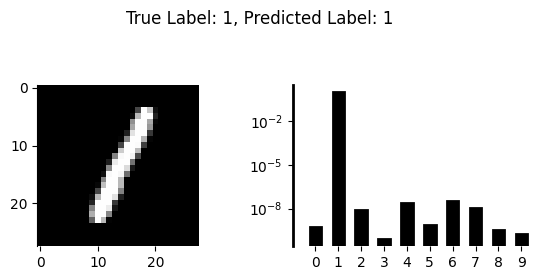

In [6]:
batch_x, batch_y = next(iter(mnist_test)) # batch_x: image pixels: 1*28*28
# batch_y: label, prediction: 1
batch_x.size(), batch_y.size() # x:[1000,1,28,28]; y: [1000]
x, y = batch_x[0].to(device), batch_y[0].to(device)
plot_mnist(x, y, model)

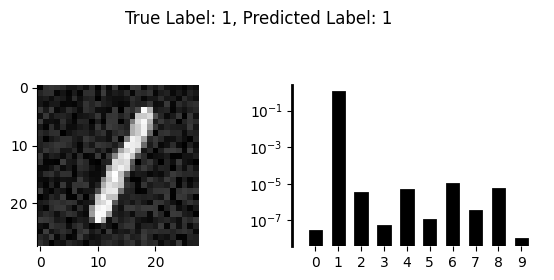

In [7]:
# Adversarial Example:
# small pixel-by-pixel modifications,
# go unnoticed while changing a neural network's prediction class
delta = torch.rand_like(x) * 1.0
plot_mnist(x + delta, y, model)

In [18]:
# before we used the gradient-based method to guide its output to a desired state
# renew the gradient each time,
# Now we perform gradient-based updates to an input in order to guide the networks
target = torch.tensor([9]).to(device)
x = x.reshape(1,1,28,28).requires_grad_(True) # because we need to include the batch dimension
x.grad = None
# for p in model.parameters():
#   p.requires_grad = False # backpropagation not update the parameters,
  # because we don't want to update the parameters
  # instead we want the input to update the model
model.eval()

outputs = model(x)
loss = torch.nn.functional.nll_loss(outputs, target) # The negative log likelihood loss
loss.backward()

# there is no optimizer.step() because we don't update the x value based on the gradient
grad = x.grad.detach().cpu()
plt.title("Gradient")
plt.imshow(grad.reshape(28, 28).numpy(), cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

<ipython-input-18-9332641a4ac7>:18: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  grad = x.grad.detach().cpu()


AttributeError: 'NoneType' object has no attribute 'detach'

Iteration: 10; Prediction: 3
Iteration: 20; Prediction: 8
Iteration: 30; Prediction: 9
Iteration: 40; Prediction: 9
Iteration: 50; Prediction: 9
Iteration: 60; Prediction: 9
Iteration: 70; Prediction: 9
Iteration: 80; Prediction: 9
Iteration: 90; Prediction: 9


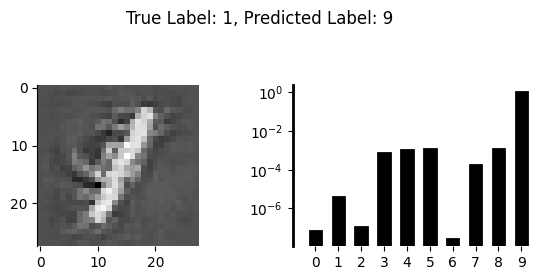

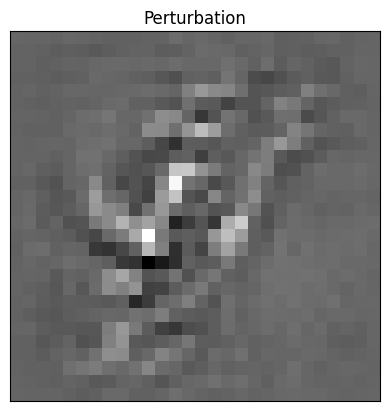

In [19]:
target = torch.tensor([9]).to(device)
x = x.reshape(1, 1, 28, 28).detach()
# initialize the gradient
delta = torch.zeros_like(x).requires_grad_(True)
# GAN treated the gradients as input not as
for i in range(1,100):
# clear gradients each step, delta = None
# each loop train the model, compute the loss, according loss function to update the gradient, update the delta.
# each time, only retain the value of delta, and clear the gradients.
#
  delta.grad = None
  outputs = model(x + delta)
  if not i % 10:
    print(f"Iteration: {i}; Prediction: {outputs.argmax()}")
  loss = torch.nn.functional.nll_loss(outputs, target)
  # compute the gradient of loss function
  loss.backward()
  grad = delta.grad.detach()
  with torch.no_grad():
    delta -= grad # update delta, not update x
plot_mnist(x + delta.detach(), y, model)

# plot perturbation (difference between benign and adversarial inputs)
plt.title("Perturbation")
plt.imshow(delta.detach().cpu().reshape(28, 28).numpy(), cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()


Iteration: 10; Prediction: 1
Iteration: 20; Prediction: 1
Iteration: 30; Prediction: 1
Iteration: 40; Prediction: 1
Iteration: 50; Prediction: 9
Iteration: 60; Prediction: 9
Iteration: 70; Prediction: 9
Iteration: 80; Prediction: 9
Iteration: 90; Prediction: 9


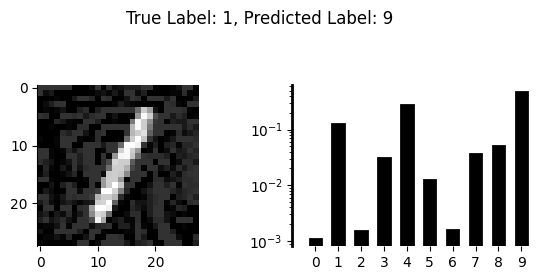

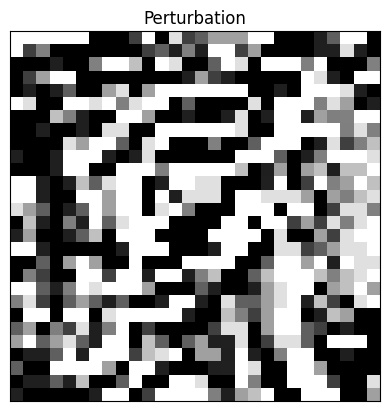

In [20]:
# We found our perturbation mostly centered.
# We try and "spread" our perturbation uniformly over the image, we might regulate the allowed perturbation magnitude at each pixel.
# This is called Projected Gradient Descent
target = torch.tensor([9]).to(device)
x = x.reshape(1, 1, 28, 28).detach()
# initialize the gradient
delta = torch.zeros_like(x).requires_grad_(True)
# GAN treated the gradients as input not as
for i in range(1,100):
# clear gradients each step, delta = None
# each loop train the model, compute the loss, according loss function to update the gradient, update the delta.
# each time, only retain the value of delta, and clear the gradients.
#
  delta.grad = None
  outputs = model(x + delta)
  if not i % 10:
    print(f"Iteration: {i}; Prediction: {outputs.argmax()}")
  loss = torch.nn.functional.nll_loss(outputs, target)
  # compute the gradient of loss function
  loss.backward()
  grad = delta.grad.detach()
  with torch.no_grad():
# we update for all pixels
        delta -= torch.sign(grad) * 0.1
        delta.clip_(min=-0.4, max=0.4)
# l2 normalization
# Lagrangian Relaxation
#.      delta -= (grad/grad.norm() + 1e-18) * 0.1
plot_mnist(x + delta.detach(), y, model)

# plot perturbation (difference between benign and adversarial inputs)
plt.title("Perturbation")
plt.imshow(delta.detach().cpu().reshape(28, 28).numpy(), cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()


__black-box__ optimization approaches can allow attackers to craft adversarial examples with only query access to a victim model.

One __adversarial defense__, called __randomized smoothing__, applies random transformations to many copies of an input and takes a majority vote over the model's predictions on the transformed inputs.

In [22]:
# Build the robust model
# instead of usually we input the variable "x + delta" to the model
# we add some randomness to the model x + delta + randomness(x+delta) * 0.001 (randomness weights)
adv_input = x + delta
noisy_prediction = []
for i in range(10):
  noisy_prediction.append(model(adv_input + torch.rand_like(adv_input) * 0.001).argmax().item())
mode = max(set(noisy_prediction), key=noisy_prediction.count)

print(f"Adversarial prediction (randomized smoothing): {mode}")


Adversarial prediction (randomized smoothing): 9


Other adversarial defenses attempt to detect malicious inputs using a variety of heuristics. However, these defenses often fail to provide meaningful guarantees against __adaptive__ attackers with knowledge of the defense. Currently, one of the best known approaches to prevent attacks is __adversarial training__, in which a model is trained on adversarial examples. This can provide some degree of robustness against attacks similar to those seen during training.

In [ ]:
# Adversarial training, trained on adversarial examples
def make_adversarial_example(x: torch.Tensor, model: torch.nn.Module, steps: int):
  assert x.ndim >= 2
  n_batch = x.shape[0]
  x = x.detach().reshape(n_batch, 1, 16000) # input dimension
  delta = torch.zeros_like(x).requires_grad_(True)
# obtain original predictions; we'll perform an "untargeted attack" in which we applied
  with torch.no_grad():
    preds = model(x).argmax(dim=-1).long()
  model.eval()
  for i in range(steps):
    delta.grad = None
    outputs = model(x + delta)
    loss = torch.nn.functional.nll_loss(outputs, preds)
    loss.backward()
    grad = delta.grad.detach()
    with torch.no_grad():
      # ascend rather than descent, because we want to generate the untarget attack
      delta += (grad/grad.norm() + 1e-18) * 0.005
  model.train()
  return(x + delta.detach())

In [38]:
torch.manual_seed(0)  # fix random seed

# load AudioMNIST dataset (if you opted to download via GitHub, this will cache the dataset as tensors)
audiomnist_train, audiomnist_test = load_audiomnist("AudioMNIST")

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load neural network classifier
model = AudioNet()
model.to(device)

# print model summary
summary(model, (1, 16000))

# uncomment this to train a model yourself!
#train_audiomnist(model, device, audiomnist_train, audiomnist_test, epochs=10)

# load pretrained weights
model.load_state_dict(torch.load('./utils/adversarial_examples/pretrained/audiomnist_classifier.pt', map_location=device))

# evaluate model. This may take a while on CPU, and should be ~98%
test_audiomnist(model, device, audiomnist_test)

/content/course-deep-learning/utils/adversarial_examples/data.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tx = torch.load(os.path.join(data_dir, 'audiomnist_tx.pt')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 100, 16002]             400
       BatchNorm1d-2           [-1, 100, 16002]             200
              ReLU-3           [-1, 100, 16002]               0
         MaxPool1d-4            [-1, 100, 8000]               0
            Conv1d-5             [-1, 64, 8000]          19,264
       BatchNorm1d-6             [-1, 64, 8000]             128
              ReLU-7             [-1, 64, 8000]               0
         MaxPool1d-8             [-1, 64, 4000]               0
            Conv1d-9            [-1, 128, 4000]          24,704
      BatchNorm1d-10            [-1, 128, 4000]             256
             ReLU-11            [-1, 128, 4000]               0
        MaxPool1d-12            [-1, 128, 2000]               0
           Conv1d-13            [-1, 128, 2000]          49,280
      BatchNorm1d-14            [-1, 12

Validation, batch 47/47: 100%|██████████| 47/47 [00:04<00:00,  9.82it/s]


Model accuracy: 98.01666666666667


In [48]:
def make_adversarial_example(x: torch.Tensor, model: torch.nn.Module, steps: int):

    # require batch dimension
    assert x.ndim >= 2
    n_batch = x.shape[0]

    x = x.detach().reshape(n_batch, 1, 16000)
    delta = torch.zeros_like(x).requires_grad_(True) # at first, we set delta = 0, having gradients

    # obtain original predictions; we'll perform an `untargeted` attack in which we simply
    # seek incorrect predictions rather than a specific class
    with torch.no_grad():
        preds = model(x).argmax(dim=-1).long()

    # evaluation mode
    model.eval()

    for i in range(steps):

        delta.grad = None

        outputs = model(x + delta)
        loss = torch.nn.functional.cross_entropy(outputs, preds)

        loss.backward()
        grad = delta.grad.detach()

        with torch.no_grad():

            # ascend rather than descend the gradient (untargeted attack)
            delta += (grad/(grad.norm() + 1e-12)) * 0.005

    # restore train mode
    model.train()

    return(x + delta.detach())


In [50]:
attack_step = 5
epochs = 5
robust_model = AudioNet()
robust_model.to(device)

optimizer = torch.optim.SGD(
    robust_model.parameters(),
    lr = 0.001,
    momentum=0.9
)

loss_fn = torch.nn.CrossEntropyLoss()


# construct the training model
# we will choose the model with best accuracy.
best_acc = 0.0
train_acc = 0.0
best_model = None

for epoch in range(epochs):
  # track loss
  training_loss = 0.0
  validation_loss = 0.0
  correct = 0
  total = 0
  pbar = tqdm(audiomnist_train, total = len(audiomnist_train))
  model.train()
  for batch_x, batch_y in enumerate(pbar):
    pbar.set_description(f"Epoch {epoch+1}/{epochs}, batch {batch_x + 1}/{len(audiomnist_train)}")
    inputs, labels = batch_y
    inputs = inputs.to(device)
    labels = labels.to(device)
    # adversarially perturb inputs
    inputs = make_adversarial_example(inputs, robust_model, attack_step)
    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = robust_model(inputs)

    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    training_loss += loss.item()
  model.eval()
  with torch.no_grad():
    pbar = tqdm(audiomnist_test, total=len(audiomnist_test))
    for batch_idx, batch_data in enumerate(pbar):

            pbar.set_description(
                f'Validation, batch {batch_idx + 1}/{len(audiomnist_test)}')

            inputs, labels = batch_data

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = robust_model(inputs)

            loss = loss_fn(outputs, labels)

            # sum validation loss
            validation_loss += loss.item()

            # calculate validation accuracy
            preds = torch.max(outputs.data, 1)[1]

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    # calculate final metrics
    validation_loss /= len(audiomnist_test)
    training_loss /= len(audiomnist_train)
    accuracy = 100 * correct / total
if accuracy > best_acc:
    print(f"New best accuracy: {accuracy}; saving model")
    best_model = copy.deepcopy(robust_model.state_dict())
    best_acc = accuracy

# use best weights
robust_model.load_state_dict(best_model)

# evaluate robust model's accuracy on "natural" (non-adversarial) data
test_audiomnist(robust_model, device, audiomnist_test)




Validation, batch 47/47: 100%|██████████| 47/47 [00:05<00:00,  8.51it/s]


New best accuracy: 95.08333333333333; saving model


Validation, batch 47/47: 100%|██████████| 47/47 [00:04<00:00, 10.50it/s]


Model accuracy: 95.06666666666666
